<a href="https://colab.research.google.com/github/contactmansi/Multimodal-Fake-News-Detection-Reddit/blob/master/CNN_2_way_text_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

We start by importing the libraries.

In [2]:
# Import libraries
import numpy as np
import time
import os
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re

import spacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import cv2 
import multiprocessing as mp
# import FunctionsTFM 
import imp
import threading


%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We also import the data.

In [4]:
# Train data 
traindata_all = pd.read_csv('/content/drive/MyDrive/CS5344/Dataset/Fakeddit datasetv2.0/all_samples/all_train.tsv', sep='\t')
# Validation data 
validata_all = pd.read_csv('/content/drive/MyDrive/CS5344/Dataset/Fakeddit datasetv2.0/all_samples/all_validate.tsv', sep='\t')
# Test data 
testdata_all = pd.read_csv('/content/drive/MyDrive/CS5344/Dataset/Fakeddit datasetv2.0/all_samples/all_test_public.tsv', sep='\t')

In [5]:

len(traindata_all)

878218

We select a subset of the dataframe with no missing values in the 'clean_title' column.

In [ ]:
# drop null

# train_2_way = traindata_all.dropna(subset=['clean_title', '2_way_label'])
# valid_2_way = validata_all.dropna(subset=['clean_title', '2_way_label'])
# test_2_way = testdata_all.dropna(subset=['clean_title', '2_way_label'])

# train_3_way = traindata_all.dropna(subset=['clean_title','3_way_label'])
# train_6_way = traindata_all.dropna(subset=['clean_title', '6_way_label'])
# len(train_2_way), len(valid_2_way), len(test_2_way), 

(802789, 84536, 84481)

In [6]:
# Train data with no missing values
# train_data = traindata_all[traindata_all['clean_title'].notnull().to_numpy()]
train_data = traindata_all.dropna(subset=['clean_title', '2_way_label'])
# Validation data with no missing values
# valid_data = validata_all[validata_all['clean_title'].notnull().to_numpy()]
valid_data = validata_all.dropna(subset=['clean_title', '2_way_label'])
# Test data with no missing values
# test_data = testdata_all[testdata_all['clean_title'].notnull().to_numpy()]
test_data = testdata_all.dropna(subset=['clean_title', '2_way_label'])
len(train_data), len(valid_data), len(test_data)

(802789, 84536, 84481)

And we separate the datasets into the texts and the labels

In [7]:
## Train data
train_news = list(train_data['clean_title'])
train_labels = list(train_data['2_way_label'])
## Valid data
valid_news = list(valid_data['clean_title'])
valid_labels = list(valid_data['2_way_label'])
## Test data
test_news = list(test_data['clean_title'])
test_labels = list(test_data['2_way_label'])

## Preprocessing

We define a function to preprocess the data. We remove punctuations and numbers and also multiple spaces.

In [8]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
# Remove puntuations and numbers and multiple spaces

train_news_clean_1 = []
valid_news_clean_1 = []
test_news_clean_1 = []
# Train
for new in train_news:
    train_news_clean_1.append(preprocess_text(new))
# Validation
for new in valid_news:
    valid_news_clean_1.append(preprocess_text(new))
# Test
for new in test_news:
    test_news_clean_1.append(preprocess_text(new))

Now  we remove stop words and perform lemmatization. We define the function to do that.

In [10]:
# Initialize  lemmatizer and  stop_words

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

# Function to remove stopwords and perform lemmatization
def remove_stopwords_lem(text):
    text = word_tokenize(text)
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    # Lematization
    lemmatized_text = []
    for word in text:
        word1 = lemmatizer.lemmatize(word, pos = "n")
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmatized_text.append(word3)
        
    text_done = ' '.join(lemmatized_text)
    return text_done

And now perform stop-words removal and lemmatization.

In [11]:
# Stop-words removal and lemmatization
train_stwrd_lem = []
valid_stwrd_lem = []
test_stwrd_lem = []

# Train
for new in train_news_clean_1:
    train_stwrd_lem.append(remove_stopwords_lem(new))
# Validation
for new in valid_news_clean_1:
    valid_stwrd_lem.append(remove_stopwords_lem(new))
# Test
for new in test_news_clean_1:
    test_stwrd_lem.append(remove_stopwords_lem(new))

We train a tokenizer using all the documents and we use the learned vocabulary in order to transform texts into sequences of ID's.

In [12]:
news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem
print(len(news_all))
tokenizer = Tokenizer(num_words = 20000) # Why this number? -- look up paper
tokenizer.fit_on_texts(news_all)

# Tokenize news

# Train
train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
# Validation
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
# Test
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)

971806


In [13]:
train_tokenized[:10], train_stwrd_lem[:10]

([[7381, 15337, 6169, 749, 347, 255],
  [1304, 624, 242, 523],
  [2647, 912, 1375, 6760, 3115, 17],
  [527, 1324],
  [508, 15, 445],
  [5, 25, 2379, 585],
  [5160, 246, 37],
  [1927, 2778, 2635, 2272, 2689, 56, 455],
  [1252, 13569],
  [5848, 1127, 3627, 771, 113, 9083, 1191, 68, 776]],
 ['walgreens offbrand mucinex engrave letter mucinex different order',
  'concern sink tiny hat',
  'hacker leak email uae ambassador u',
  'flower neighborhood',
  'puppy take view',
  'find face sheet music',
  'escobar couple think',
  'bride groom exchange vow fatal shoot wed',
  'major thermos',
  'rabbi meat clone pig could kosher jew eat milk'])

Obtain the vocabulary length

In [14]:
vocab_size = len(tokenizer.word_index)
print("Vocabulary length: ", vocab_size)

Vocabulary length:  142720


Now we pad the sequences of numbers generated by the tokenizer. But firstly we check how many sequences are shorter than a given length. We start by defining a function that counts the length of each sequence.

In [15]:
# Function to count the length of each sequence
def length_squences(data):
    lengths = []
    for i in range(len(data)):
        lengths.append(len(data[i]))
    return lengths

Now we count the lenghts of all the sequences in the training, validation and test set and we check what % of sequences in the train, validation and test sets are smaller than a given length when they are tokenized.

In [16]:
length = [10, 15, 20, 25]

# Train set
lengths_train = np.array(length_squences(train_tokenized))
perc_length_train = []
for lgth in length:
   perc_length_train.append( sum(lengths_train < lgth)/len(lengths_train)*100)
print("Percentages (train):", perc_length_train)

# Validation set 
lengths_valid = np.array(length_squences(valid_tokenized))
perc_length_valid = []
for lgth in length:
   perc_length_valid.append( sum(lengths_valid < lgth)/len(lengths_valid)*100)
print("Percentages (validation):", perc_length_valid)

# Test set
lengths_test = np.array(length_squences(test_tokenized))
perc_length_test = []
for lgth in length:
   perc_length_test.append( sum(lengths_test < lgth)/len(lengths_test)*100)
print("Percentages (test):", perc_length_test)

Percentages (train): [90.67986731258151, 98.47681022036923, 99.52640108422014, 99.85089481794095]
Percentages (validation): [90.60755181224567, 98.44326677391881, 99.52919466262894, 99.83793886628182]
Percentages (test): [90.52923142481741, 98.47302943857198, 99.50876528450185, 99.83901705708976]


We plot the results.

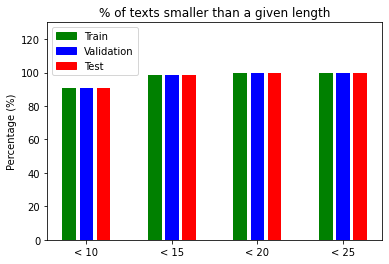

In [17]:
import matplotlib.pyplot as plt
# create dataset
bars = list(sum(zip(perc_length_train, perc_length_valid, perc_length_test), ()))
labels = ['< 10', '< 15', '< 20', '< 25']

x_pos_bars = [1, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 18]
x_pos_labels = [2, 7, 12, 17]

# Colors and mapping to values
colors = ['g', 'b', 'r']
colors_values = {'Train':'g', 'Validation':'b', 'Test': 'r'}    

labels2 = list(colors_values.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_values[label]) for label in labels2]
# Make the plot
plt.bar(x_pos_bars, bars,color = colors, label = colors_values)

# Create names on the x-axis
plt.xticks(x_pos_labels, labels)
plt.legend(handles, labels2)
plt.ylim([0, 130])
#plt.xlabel('Metrics')
plt.ylabel('Percentage (%)')
plt.title('% of texts smaller than a given length')
plt.show()

As we can see almost all news are smaller than **15** in length when tokenized so choosing this lenght to pad/truncate the tokenized news will not eliminate any information from the news in almost any case.

In [18]:
# Pad/truncate the tokenized news

# Train
train_tokenized_pad = pad_sequences(train_tokenized, maxlen = 15, truncating = 'pre', padding = 'pre')
# Validation
valid_tokenized_pad = pad_sequences(valid_tokenized, maxlen = 15, truncating = 'pre', padding = 'pre')
# Test
test_tokenized_pad = pad_sequences(test_tokenized, maxlen = 15, truncating = 'pre', padding = 'pre')

Now let's setup the GPU environment. The colab provides a free GPU to use. Do as follows:

Runtime -> Change Runtime Type -> select GPU in Hardware accelerator
Click connect on the top-right
After connecting to one GPU, you can check its status using nvidia-smi comman

In [19]:
!nvidia-smi
torch.cuda.is_available()

Tue Oct 18 03:16:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |    840MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In order to use the data with torch we have to transform the arrays into dataloader objects but first they need to be transformed into tensors.

### Word embeddings

We will try different word embeddings and select the one which performs better. We create two functions: one to load the word embeddings and the other to create the embedding matrix.

In [21]:
# Function to load the word embeddings

def load_embedd(filename):
    words = []
    vectors = []
    file = open(filename,'r', encoding="utf8")
    for line in file.readlines():
       row = line.split(' ')
       vocab = row[0]
       embd = row[1:len(row)]
       embd[-1] = embd[-1].rstrip()
       embd = list(map(float,embd)) # convert string to float
       words.append(vocab)
       vectors.append(embd)
    file.close()
    return words,vectors

Function to create the embedding matrix.

In [22]:
# Function to create the embedding matrix

def embed_matx(word_index, vocab, embeddings, length_vocab, length_embedding):
    embedding_matrix = np.zeros((length_vocab +1, length_embedding))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector =  embeddings[idx]
            embedding_matrix[i] = vector
        if i == length_vocab:
            break
    return embedding_matrix

#### Glove (300 d)

We use GloVe embeddings of dimension 300.

In [23]:
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "/content/drive/MyDrive/CS5344/Dataset/glove.6B.300d.txt")

Now we create the embbeding matrix.

In [24]:
word_index = tokenizer.word_index
# Embedding matrix
embedding_matrix_gv_300 = embed_matx(word_index = word_index, 
                                     vocab = vocab_gv_300, 
                                     embeddings = vectors_gv_300, 
                                     length_vocab = vocab_size, 
                                     length_embedding = 300)

## Model Training and Testing performance

We join the **train** and **validation** datasets and we train the model with this dataset using the optimal number of epochs. Then we evaluate the model with the **test** set. First we need to modify a bit the class used previously.

In [25]:
class CNN(nn.Module):
    def __init__(self, nlabels, train_parameters = True, random_embeddings = False): 
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim = 300)
        
        if random_embeddings == True:
            self.embedding.weight = nn.Parameter(torch.rand(vocab_size+1, 300), requires_grad = train_parameters)
        else:
            self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix_gv_300), requires_grad = train_parameters)
            
        # Filters for the CNN    
        self.filter_sizes = [2,3,4,5]
        self.num_filters = 50
        
        # Concolutional layers
        self.convs_concat = nn.ModuleList([nn.Conv2d(1, self.num_filters, (K, 300)) for K in self.filter_sizes])
        
        # Linear layers
        self.linear1 = nn.Linear(200,128)
  
        self.linear2 = nn.Linear(128,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        # Unsqueeze
        x = x.unsqueeze(1)
        # Convolution
        x = [F.relu(conv(x.float())).squeeze(3) for conv in self.convs_concat]
        # Max-pooling
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] 
        x = torch.cat(x, 1)
        # Linear layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.logsoftmax(x) 
        return x

In [26]:
class CNN_train_validation(CNN):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100,lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        # A list to store the loss evolution along training
        self.loss_during_training = []
        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader):
        
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):

            start_time = time.time()
            # Random data permutation at each epoch
            running_loss = 0.
            i = 0
            length = 0
            accuracies = []
            
            for news, labels in trainloader:             
        
                self.optim.zero_grad()  # Reset gradients
                out = self.forward(news.int())
                loss = self.criterion(out,labels.long())
                loss.backward()
                running_loss += loss.item()
                self.optim.step()
                top_p, top_class = out.topk(1, dim=1)
                equals = (top_class == labels.view(news.shape[0], 1))
                length += news.shape[0]
                accuracies.append(sum(equals))
                accuracy = sum(accuracies)/length
                i += 1
                if i%1000 == 0:
                    print(" Train accuracy: ", accuracy)
                
            self.loss_during_training.append(running_loss/len(trainloader))
            end_time = time.time()
            print("Elapsed time for epoch: {e}: ", end_time-start_time)

                
    def eval_performance(self,dataloader):
        predictions = np.empty((1,1))

        with torch.no_grad():

            for news,labels in dataloader:
                
                logprobs = self.forward(news)  
                top_p, top_class = logprobs.topk(1, dim=1)
                
                top_class_array = np.array(top_class)
                predictions = np.concatenate((predictions, top_class_array), axis = 0)
                
        return predictions[1:]

Now we join the train and validation sets.

In [27]:
# Join train and validation sequences
train_valid_tokenized_pad = np.concatenate((train_tokenized_pad, valid_tokenized_pad), axis = 0)
# Join train and validation labels
train_valid_labels = np.concatenate((np.array(train_labels), np.array(valid_labels)), axis = 0)

# Create tensor objects

# Train + validation
train_valid_tensor = torch.Tensor(train_valid_tokenized_pad).int()
# Test
test_tensor =  torch.Tensor(test_tokenized_pad).int()

# Tranform tensors into data loader objects

# Train + validation
train_valid_set = TensorDataset(train_valid_tensor, torch.Tensor(np.array(train_valid_labels)))
train_valid_loader = DataLoader(train_valid_set, batch_size=64)
# Test
test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
testloader =  DataLoader(test_set, batch_size=64)

### Random embeddings  + Training embeddings

In [ ]:
# Initialize model
CNN_test_train_random = CNN_extended(nlabels = 6, epochs=1, lr=0.003, train_parameters = True, random_embeddings = True)
# Train model
CNN_test_train_random.trainloop(train_valid_loader)
# Get predictions
predictions1 = CNN_test_train_random.eval_performance(testloader)

 Train accuracy:  tensor([0.5919])
 Train accuracy:  tensor([0.6198])
 Train accuracy:  tensor([0.6408])
 Train accuracy:  tensor([0.6534])
 Train accuracy:  tensor([0.6628])
 Train accuracy:  tensor([0.6697])
 Train accuracy:  tensor([0.6752])
 Train accuracy:  tensor([0.6800])
 Train accuracy:  tensor([0.6841])
 Train accuracy:  tensor([0.6874])
Elapsed time:  7168.229678869247


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions1))

              precision    recall  f1-score   support

           0       0.71      0.87      0.79     23507
           1       0.63      0.26      0.37      3514
           2       0.70      0.48      0.57     11297
           3       0.72      0.07      0.13      1224
           4       0.75      0.84      0.79     17472
           5       0.71      0.54      0.61      2305

    accuracy                           0.72     59319
   macro avg       0.70      0.51      0.54     59319
weighted avg       0.72      0.72      0.70     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions1, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.63      0.26      0.37      3514
           2       0.70      0.48      0.57     11297
           3       0.72      0.07      0.13      1224
           4       0.75      0.84      0.79     17472
           5       0.71      0.54      0.61      2305

   micro avg       0.73      0.62      0.67     35812
   macro avg       0.70      0.44      0.49     35812
weighted avg       0.72      0.62      0.65     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions1))

[[20543   198  1057    12  1512   185]
 [ 1439   923   206     5   885    56]
 [ 3499   109  5391     7  2113   178]
 [  796    55    87    85   170    31]
 [ 1803   139   791     5 14672    62]
 [  706    51   131     4   172  1241]]


### GloVe embeddings  + Training embeddings

In [ ]:
# Initialize model
CNN_test_train_not_random = CNN_train_validation(
    nlabels = 2, epochs=5, lr=0.003, train_parameters = True, random_embeddings = False)
# Train model
CNN_test_train_not_random.trainloop(train_valid_loader)
# Get predictions
predictions_2 = CNN_test_train_not_random.eval_performance(testloader)

 Train accuracy:  tensor([0.7781])
 Train accuracy:  tensor([0.7868])
 Train accuracy:  tensor([0.7934])
 Train accuracy:  tensor([0.7974])
 Train accuracy:  tensor([0.7999])
 Train accuracy:  tensor([0.8032])
 Train accuracy:  tensor([0.8052])
 Train accuracy:  tensor([0.8069])
 Train accuracy:  tensor([0.8083])
 Train accuracy:  tensor([0.8097])


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_2))

In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_2, labels = [1,2,3,4,5]))

In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_2))

### Random embeddings  +  Not training embeddings

In [ ]:
# Initialize model
CNN_test_not_train_random = CNN_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = True)
# Train model
CNN_test_not_train_random.trainloop(train_valid_loader)
# Get predictions
predictions_3 = CNN_test_not_train_random.eval_performance(testloader)

 Train accuracy:  tensor([0.5530])
 Train accuracy:  tensor([0.5597])
 Train accuracy:  tensor([0.5638])
 Train accuracy:  tensor([0.5688])
 Train accuracy:  tensor([0.5730])
 Train accuracy:  tensor([0.5763])
 Train accuracy:  tensor([0.5796])
 Train accuracy:  tensor([0.5827])
 Train accuracy:  tensor([0.5856])
 Train accuracy:  tensor([0.5880])
Elapsed time:  743.8465197086334
 Train accuracy:  tensor([0.6123])
 Train accuracy:  tensor([0.6118])
 Train accuracy:  tensor([0.6123])
 Train accuracy:  tensor([0.6127])
 Train accuracy:  tensor([0.6134])
 Train accuracy:  tensor([0.6141])
 Train accuracy:  tensor([0.6147])
 Train accuracy:  tensor([0.6150])
 Train accuracy:  tensor([0.6156])
 Train accuracy:  tensor([0.6159])
Elapsed time:  741.4050281047821
 Train accuracy:  tensor([0.6202])
 Train accuracy:  tensor([0.6200])
 Train accuracy:  tensor([0.6203])
 Train accuracy:  tensor([0.6208])
 Train accuracy:  tensor([0.6211])
 Train accuracy:  tensor([0.6217])
 Train accuracy:  tensor

In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_3))

              precision    recall  f1-score   support

           0       0.63      0.81      0.71     23507
           1       0.81      0.03      0.06      3514
           2       0.52      0.34      0.41     11297
           3       0.30      0.02      0.04      1224
           4       0.67      0.78      0.72     17472
           5       0.69      0.29      0.41      2305

    accuracy                           0.63     59319
   macro avg       0.60      0.38      0.39     59319
weighted avg       0.63      0.63      0.59     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_3, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.81      0.03      0.06      3514
           2       0.52      0.34      0.41     11297
           3       0.30      0.02      0.04      1224
           4       0.67      0.78      0.72     17472
           5       0.69      0.29      0.41      2305

   micro avg       0.63      0.51      0.56     35812
   macro avg       0.60      0.29      0.33     35812
weighted avg       0.62      0.51      0.51     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_3))

[[19038    13  1838    22  2467   129]
 [ 2119   112   288     8   953    34]
 [ 4362     5  3845     3  2992    90]
 [  904     0   123    29   150    18]
 [ 2792     7   974    24 13640    35]
 [ 1093     2   307    11   221   671]]


### GloVe embeddings  +  Not training embeddings

In [28]:
# Initialize model
CNN_test_not_train_not_random = CNN_train_validation(
    nlabels = 2, epochs=10, lr=0.003, train_parameters = False, random_embeddings = False)
# Train model
CNN_test_not_train_not_random.trainloop(train_valid_loader)
# Get predictions
predictions_4 = CNN_test_not_train_not_random.eval_performance(testloader)

 Train accuracy:  tensor([0.7625])
 Train accuracy:  tensor([0.7698])
 Train accuracy:  tensor([0.7762])
 Train accuracy:  tensor([0.7802])
 Train accuracy:  tensor([0.7825])
 Train accuracy:  tensor([0.7856])
 Train accuracy:  tensor([0.7877])
 Train accuracy:  tensor([0.7894])
 Train accuracy:  tensor([0.7908])
 Train accuracy:  tensor([0.7920])
 Train accuracy:  tensor([0.7931])
 Train accuracy:  tensor([0.7943])
 Train accuracy:  tensor([0.7952])
Elapsed time:  717.7152919769287
 Train accuracy:  tensor([0.8108])
 Train accuracy:  tensor([0.8104])
 Train accuracy:  tensor([0.8117])
 Train accuracy:  tensor([0.8125])
 Train accuracy:  tensor([0.8125])
 Train accuracy:  tensor([0.8140])
 Train accuracy:  tensor([0.8148])
 Train accuracy:  tensor([0.8155])
 Train accuracy:  tensor([0.8161])
 Train accuracy:  tensor([0.8166])
 Train accuracy:  tensor([0.8172])
 Train accuracy:  tensor([0.8176])
 Train accuracy:  tensor([0.8179])
Elapsed time:  710.1242599487305
 Train accuracy:  tensor

In [29]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_4))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81     42155
           1       0.82      0.77      0.80     42326

    accuracy                           0.80     84481
   macro avg       0.80      0.80      0.80     84481
weighted avg       0.80      0.80      0.80     84481



In [30]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_4, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.82      0.77      0.80     42326
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

   micro avg       0.82      0.77      0.80     42326
   macro avg       0.16      0.15      0.16     42326
weighted avg       0.82      0.77      0.80     42326



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [31]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_4))

[[34995  7160]
 [ 9603 32723]]
